# Part A Convolution Neural Networks
| Name                  | Admin No. | Class          |
| --------------------- | --------- | -------------- |
| Ernest Ng Sheng Kang  | P2222668  | DAAA/FT/2B/06  |
## Background Infomation



## Initializing Libaries

In [2]:
import tensorflow as tf
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
from sklearn.metrics import classification_report
from keras.utils import to_categorical
import keras_tuner as kt
import visualkeras
from keras.regularizers import l1, l2
from keras.layers import AveragePooling2D, ZeroPadding2D, BatchNormalization, Activation, MaxPool2D, Add
from keras.models import Sequential
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Normalization, Dense, Conv2D, Dropout, BatchNormalization, ReLU
from keras.models import Sequential
from keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import Input
from keras.optimizers import *
from keras.callbacks import EarlyStopping

Using TensorFlow backend


## Checking GPU

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### Fixing random seed

In [4]:
seed = 69
np.random.seed(seed)
tf.random.set_seed(seed)

## factors to consider/research

- overfitting (how to prevent it)
    - data augmentation
    - L1 and L2 regulazation
    - dropout layers
    - 
- how does the various parameter of a model (dense layers, parameters of dense layers, activation fucntions, optimizers, learning rate, weigh initilzation, et...)
- affect it eg its accuracy and how does it learn/ will it have vanishing gradient / exploding gradient or any other problems?
- training time and efficiency
    - batch size
- 

## Problem statement
Our problem for this assignment is to create a deep learning model to predict vegatables using the dataset on vegatables.

We need to create 2 seperate final models to predict images on 2 different input sizes:
- 31 x 31
- 128 x128 

## Goals of this project
### Generalise to data well
> To make sure our model is able to generalise to data well, we need to __minimize__ the difference between our training accuracy and test accuracy.
### Accuracy
> In order to minimize avoidable bias, it is important for the model to achieve a training set accuracy of at least __85%__ or higher, which signifies a reasonable level of accuracy.

# Importing Datasets

In [5]:
directory_train = './datasets/Dataset for CA1 part A/train'
directory_test = './datasets/Dataset for CA1 part A/test'
directory_validation = './datasets/Dataset for CA1 part A/validation'

def dataset(directory,image_size,seed=seed,batch_size=64):
    dataset = tf.keras.preprocessing.image_dataset_from_directory(
        directory,
        labels='inferred',
        label_mode='categorical',
        color_mode='grayscale',
        image_size=image_size,
        shuffle=True,
        seed=seed,
        batch_size=batch_size
    )
    return dataset


In [6]:
dataset_train_31 = dataset(directory_train,(31,31))
dataset_test_31 = dataset(directory_test,(31,31))
dataset_validation_31 = dataset(directory_validation,(31,31))

dataset_train_128 = dataset(directory_train,(128,128))
dataset_test_128 = dataset(directory_test,(128,128))
dataset_validation_128 = dataset(directory_validation,(128,128))

Found 9028 files belonging to 15 classes.
Found 3000 files belonging to 15 classes.
Found 3000 files belonging to 15 classes.
Found 9028 files belonging to 15 classes.
Found 3000 files belonging to 15 classes.
Found 3000 files belonging to 15 classes.


# EDA
What can we get from our EDA?
- How does the average image look like for each class?
- How is the class distribution?
- How does a sample image look like for each class?


In [7]:
class_labels = [
    "Bean",
    "Bitter Gourd",
    "Bottle Gourd",
    "Brinjal",
    "Broccoli",
    "Cabbage",
    "Capsicum",
    "Carrot",
    "Cauliflower",
    "Cucumber",
    "Papaya",
    "Potato",
    "Pumpkin",
    "Radish",
    "Tomato",
]

In [8]:
for images, labels in dataset_train_31.take(1):
    print("31x31 Batch Shape:", images.shape)
for images, labels in dataset_train_128.take(1):
    print("128x128 Batch Shape:", images.shape)

31x31 Batch Shape: (64, 31, 31, 1)
128x128 Batch Shape: (64, 128, 128, 1)


Our image shapes are 31x31 and 128x128, with a single colour channel.

We have a default batch size of 64, since tf.keras.preprocessing.image_dataset_from_directory requires a default batch size or else the model wont fit properly. Fortunatly we can set our batch size again when we fit our models.

### Visualizing our datasets

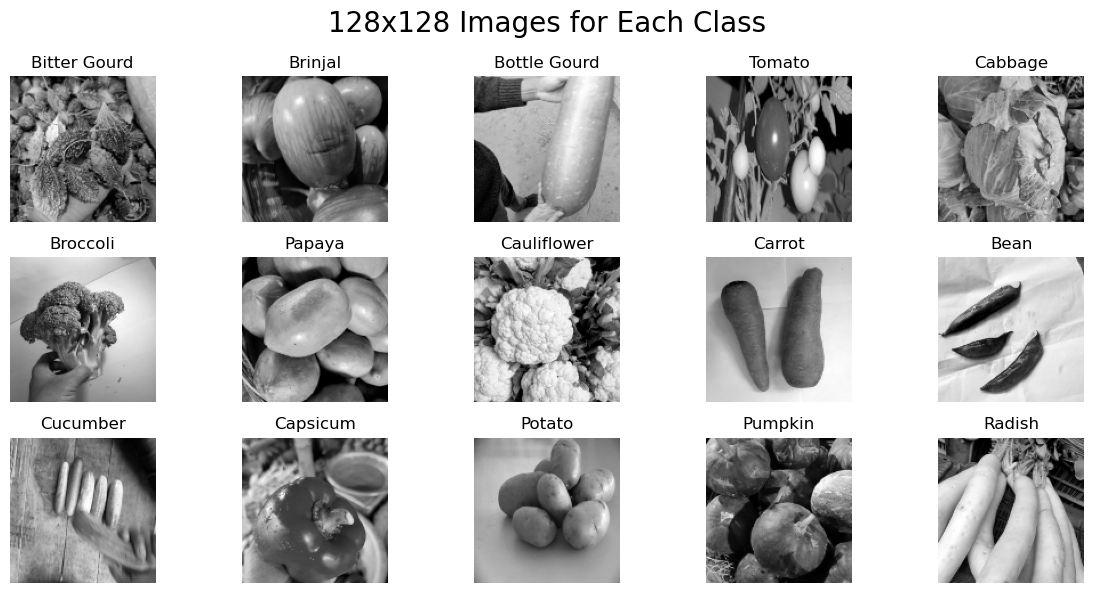

In [9]:
def plot_unique_images(dataset, title, class_labels):
    plt.figure(figsize=(12, 6))
    plt.suptitle(title, fontsize=20)
    unique_images = []  
    unique_labels = []  

    #get unique images
    for images, labels in dataset:
        for i, label in enumerate(labels):
            label_idx = tf.argmax(label).numpy()
            if label_idx not in unique_labels:
                unique_images.append(images[i].numpy().astype("uint8"))
                unique_labels.append(label_idx)

            if len(unique_images) == len(class_labels):
                break 
        if len(unique_images) == len(class_labels):
            break  

    num_images = len(unique_images)
    row = int(np.sqrt(num_images))
    col = int(np.ceil(num_images / row))

    for i in range(num_images):
        ax = plt.subplot(row, col, i + 1)
        plt.imshow(unique_images[i], cmap='gray')
        plt.title(class_labels[unique_labels[i]])
        plt.axis("off")

    plt.tight_layout()
    plt.show()

plot_unique_images(dataset_train_128, '128x128 Images for Each Class', class_labels)

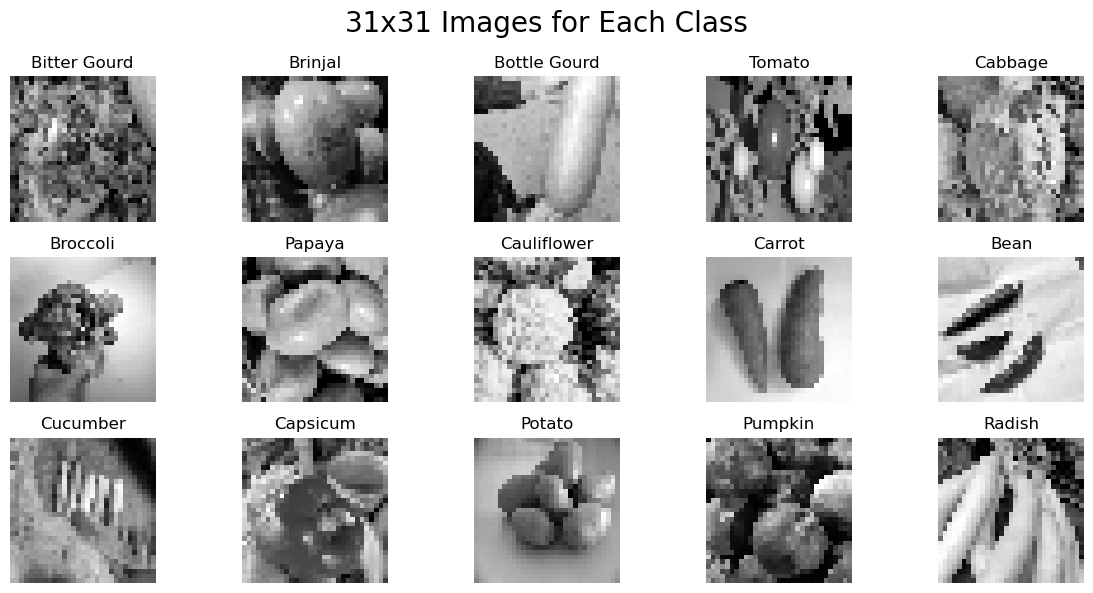

In [10]:
plot_unique_images(dataset_train_31, '31x31 Images for Each Class', class_labels)

Observations:
- We can hardly differentiate some images between classes for images of size 31x31(brocoli,bitter_gourd), hopefully our model can better differeniate these images better than humans!

Now lets get a wider sample range of pictures of every class, to see how diverse the classes are.

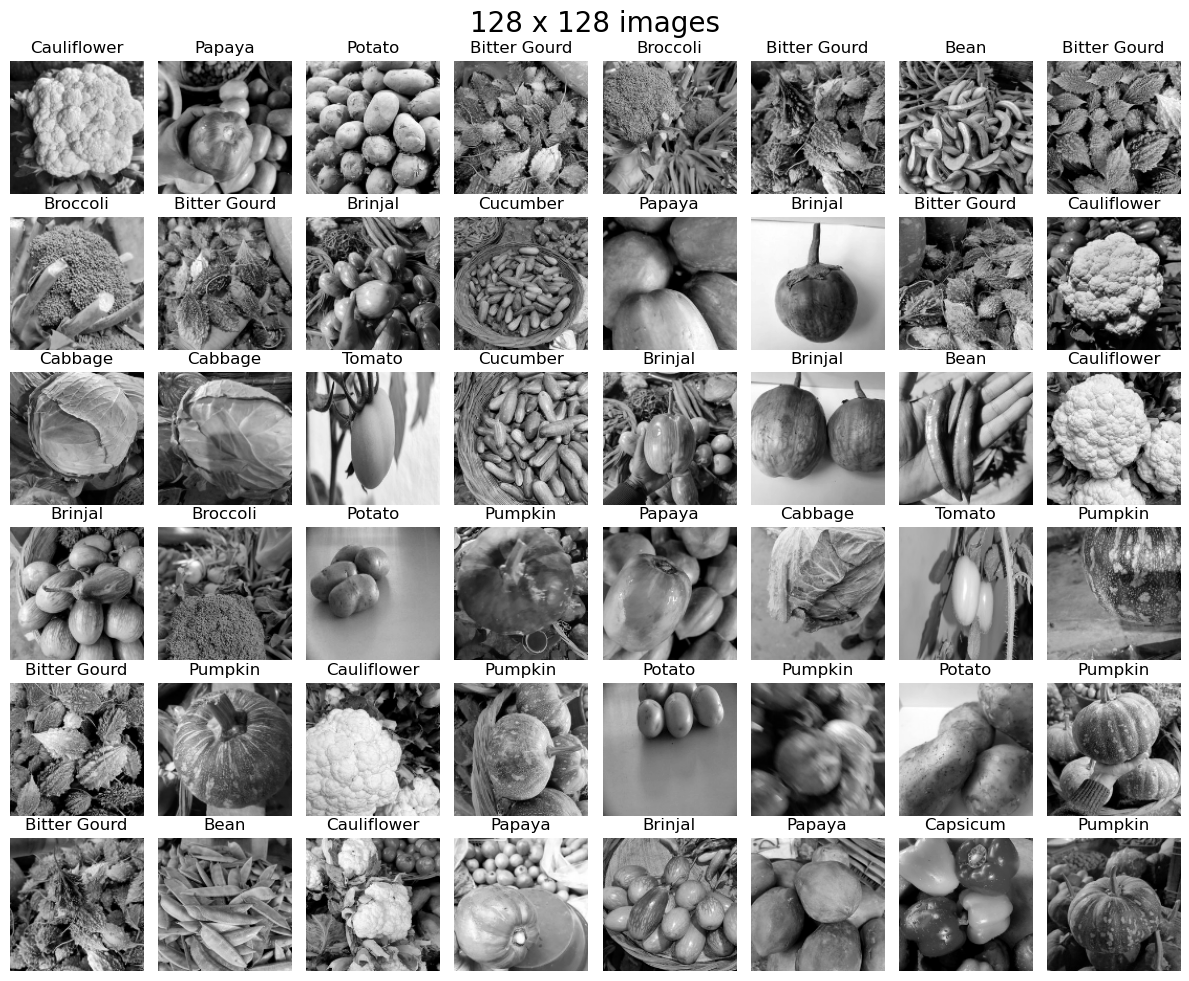

In [11]:
def plot_dataset_huge(amtOfImages, dataset,title,class_labels):
    plt.figure(figsize=(12, 10))
    plt.suptitle(title, fontsize=20)
    for images, labels in dataset.take(1):
        num_images = len(images)  

        row = int(np.sqrt(amtOfImages))
        col = int(np.ceil(amtOfImages / row))
            
        for i in range(min(amtOfImages, num_images)):
            ax = plt.subplot(row, col, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"), cmap='gray')
            plt.title(class_labels[np.argmax(labels[i])])
            plt.axis("off")

    plt.subplots_adjust(wspace=0.1, hspace=0.01)
    plt.tight_layout()
    plt.show()

plot_dataset_huge(48,dataset_train_128,'128 x 128 images',class_labels)

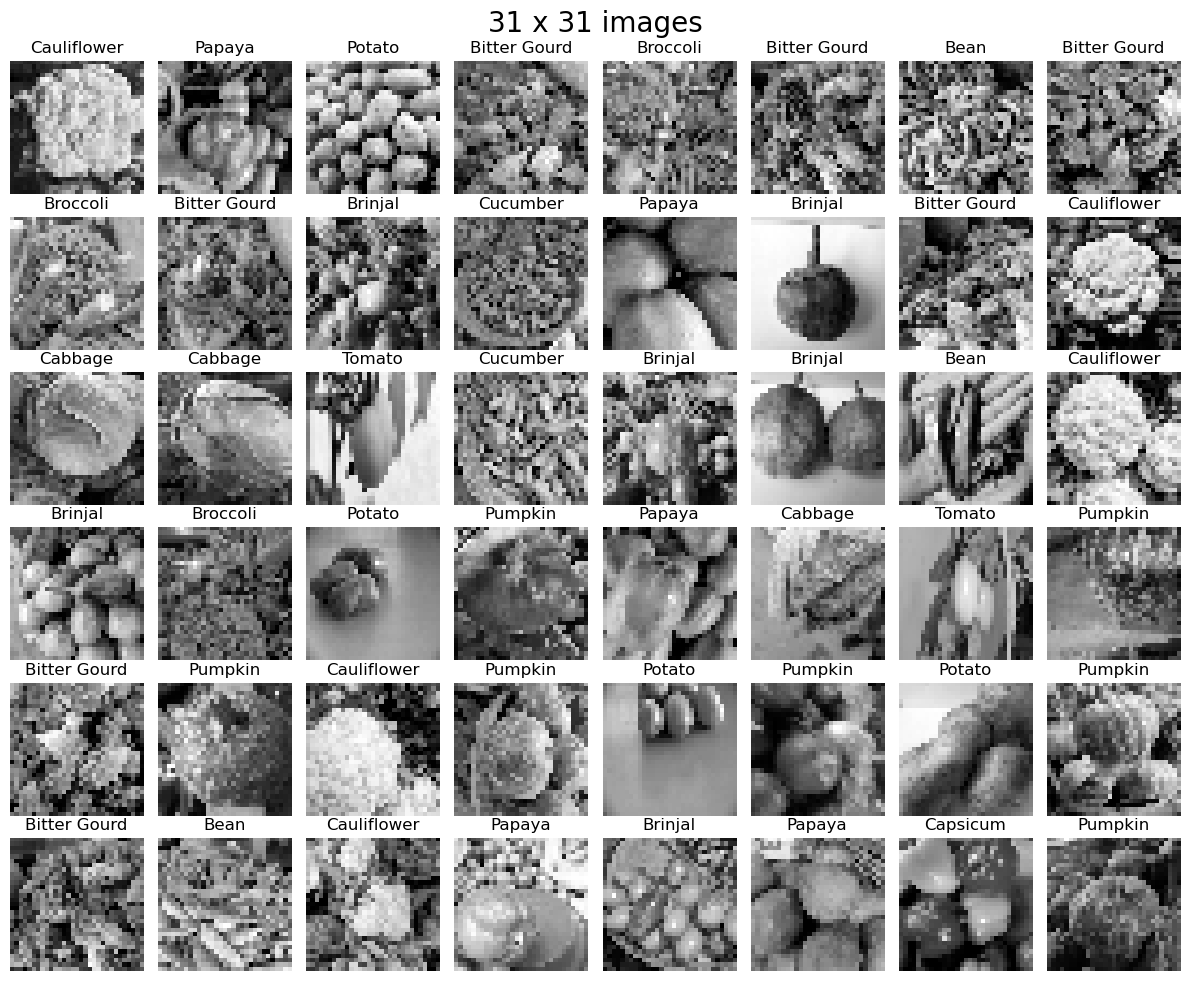

In [12]:
plot_dataset_huge(48,dataset_train_31,'31 x 31 images',class_labels)

Observations:
- Cauliflowers and Potatos are easily differentiable, with potatos usually having a white background and cauliflowers having 

### Class Distribution

In [13]:
class_counts_df = pd.DataFrame(columns=class_labels)

def count_classes(dataset, class_labels):
    class_count = {label: 0 for label in class_labels}
    for _, labels in dataset:
        for label in labels:
            class_name = class_labels[tf.argmax(label)]
            class_count[class_name] += 1
    return class_count

class_counts_df.loc['Validation'] = count_classes(dataset_validation_128, class_labels)
class_counts_df.loc['Training'] = count_classes(dataset_train_128, class_labels)
class_counts_df.loc['Test'] = count_classes(dataset_test_128, class_labels)
class_counts_df.loc['Total Classes'] = class_counts_df.sum()
class_counts_df['Total Datasets'] = class_counts_df.sum(axis=1)

class_counts_df

,Bean,Bitter Gourd,Bottle Gourd,Brinjal,Broccoli,Cabbage,Capsicum,Carrot,Cauliflower,Cucumber,Papaya,Potato,Pumpkin,Radish,Tomato,Total Datasets
Validation,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,3000
Training,780,720,441,868,750,503,351,256,587,812,566,377,814,248,955,9028
Test,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,3000
Total Classes,1180,1120,841,1268,1150,903,751,656,987,1212,966,777,1214,648,1355,15028


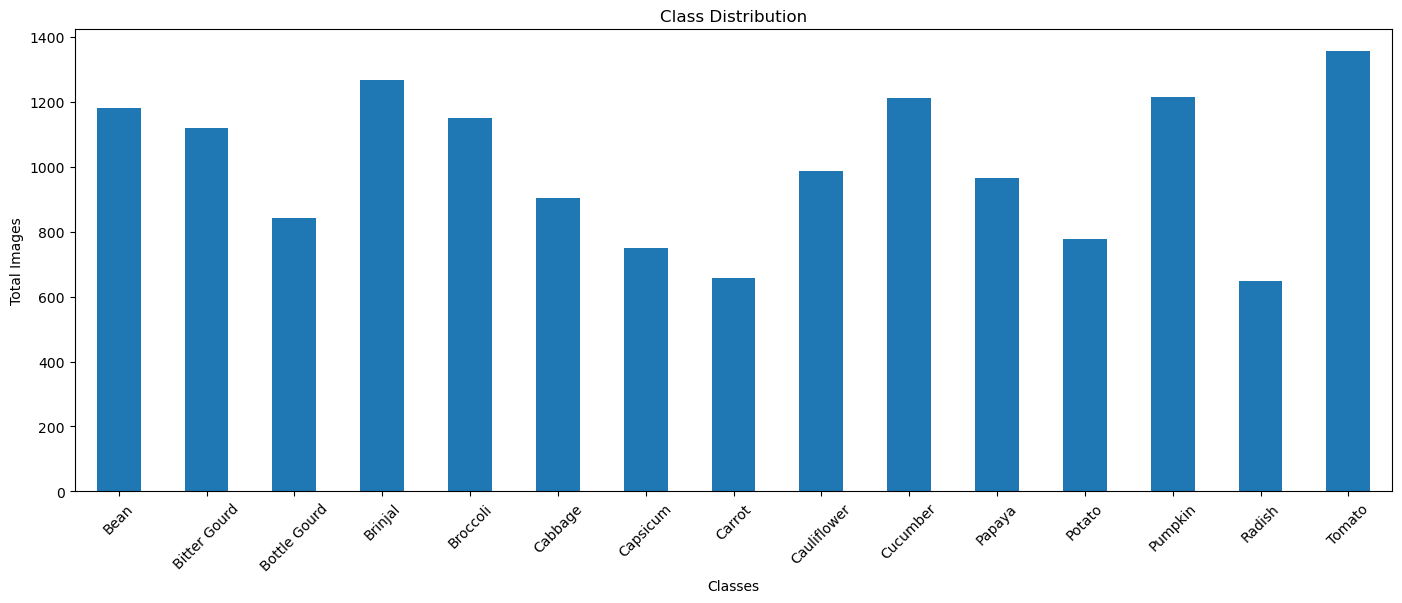

In [14]:
class_counts_df_plot = class_counts_df.drop(['Total Datasets'], axis=1)
class_counts_df_plot = class_counts_df_plot.T
class_counts_df_plot

# Plot the bar graph
class_counts_df_plot['Total Classes'].plot(kind='bar', figsize=(17, 6))
plt.xlabel('Classes')
plt.ylabel('Total Images')
plt.title('Class Distribution')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

We can see that we have an class imbalance for our train dataset. Oh No!! What should we do?
- There are quite alot of solutions for this problem, here are 3 main solutions:
    1. We can __augment our data on the minority classes__(Bottle_gourd, carrots and radish). However we want to also augment our other images classes to prevent overfitting so this is not a good option.
    2. We can __oversample or undersample our minority or majority classes__.However oversampling can lead to overfitting without any data augmentation.
    3. We can __modify the loss function__ to assign different weights to each class, such as increasing the loss weigh for our minority class.


#### Why will we be using differing class weights?
We will be assigning different weights for each class for a few reasons:
- It helps __preserve our existing data__, as in our case we have classes that have a much smaller number of samples (Carrots and Radishs) compared to others.We effectively tell the model to pay more attention to the minority classes. 
- __Prevents overfitting__. As our model is encouraged to strike a balance between minimizing the loss and ensuring that all our classes are predicted accurately. 
- __Simpler than Image oversampling__. Using differing class weights can be more advantagous than image oversampling due to its increased computational costs and potential for overfitting without image augmentation.

In [15]:
class_counts_df_plot['Training'].values

array([780, 720, 441, 868, 750, 503, 351, 256, 587, 812, 566, 377, 814,
       248, 955], dtype=int64)

We will be calculating the class weights using only the train data, as it is the only dataset with imbalanced classes.

In [16]:
class_weights = tf.math.reciprocal(tf.constant(
(class_counts_df_plot['Training'].values).astype(np.float32)))

# Normalize the class weights
class_weights = class_weights / tf.reduce_sum(class_weights)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights.numpy())}

print("Class Weights:", class_weights_dict)

Class Weights: {0: 0.042979263, 1: 0.046560865, 2: 0.07601774, 3: 0.038621914, 4: 0.04469843, 5: 0.06664775, 6: 0.09550946, 7: 0.13095243, 8: 0.05711043, 9: 0.041285496, 10: 0.05922937, 11: 0.088922605, 12: 0.041184057, 13: 0.1351767, 14: 0.03510348}


#### Another important question to ask is. 
- What are our pixel distributions for our datasets? and what is the std and mean of them? 

In [17]:
def compute_statistics(dataset,title):
    pixel_min = float('inf') 
    pixel_max = float('-inf')
    pixel_sum = 0
    pixel_sum_square = 0
    num_pixels = 0

    for images, _ in dataset:
        for image in images:
            # Calculate min and max pixel values
            pixel_min = min(pixel_min, np.min(image))
            pixel_max = max(pixel_max, np.max(image))

            # Update sum and sum of squares for mean and std calculation
            pixel_sum += np.sum(image)
            pixel_sum_square += np.sum(image ** 2)
            num_pixels += np.prod(image.shape)

    # Calculate mean and std
    pixel_mean = pixel_sum / num_pixels
    pixel_std = np.sqrt((pixel_sum_square / num_pixels) - (pixel_mean ** 2))

    print(title)
    print("Min Pixel Value:", pixel_min)
    print("Max Pixel Value:", pixel_max)
    print("Mean Pixel Value:", pixel_mean)
    print("Standard Deviation:", pixel_std)

    return

compute_statistics(dataset_train_31,'Training Images')
compute_statistics(dataset_test_31,'Test Images')
compute_statistics(dataset_validation_31,'Validation Images')

Training Images
Min Pixel Value: 0.0
Max Pixel Value: 255.0
Mean Pixel Value: 114.34127948859215
Standard Deviation: 55.387912533676406
Test Images
Min Pixel Value: 0.0
Max Pixel Value: 255.0
Mean Pixel Value: 114.66371605098855
Standard Deviation: 55.07995207606749
Validation Images
Min Pixel Value: 0.0
Max Pixel Value: 255.0
Mean Pixel Value: 113.78344607803287
Standard Deviation: 55.49623592897191


- Our pixel values range from 0 to 255, which is expected as grayscale images typically have pixel values ranging from 0 (black) to 255 (white). 
- Our average pixel is around 114, which means that our images are not heavily skewed toward either very dark or very bright values.

### Image Averaging
We will be using only the test and validation datasets for averaging as the train set has class imbalance and may result in inaccurate results.

In [18]:
def calculate_mean_image(datasets, image_size, title):
    pixel_sum = np.zeros((image_size[0], image_size[1]), dtype=np.float64)
    num_images = 0
    mean_images = np.zeros((image_size[0], image_size[1]), dtype=np.float64)

    for dataset in datasets:
        for images, _ in dataset:
            for image in images:
                pixel_sum += np.squeeze(image, axis=-1)
                num_images += 1

    # Calculate the mean image
    mean_image = pixel_sum / num_images
    mean_images = mean_images + mean_image
    
    mean_images = mean_images / len(datasets)

    return mean_images

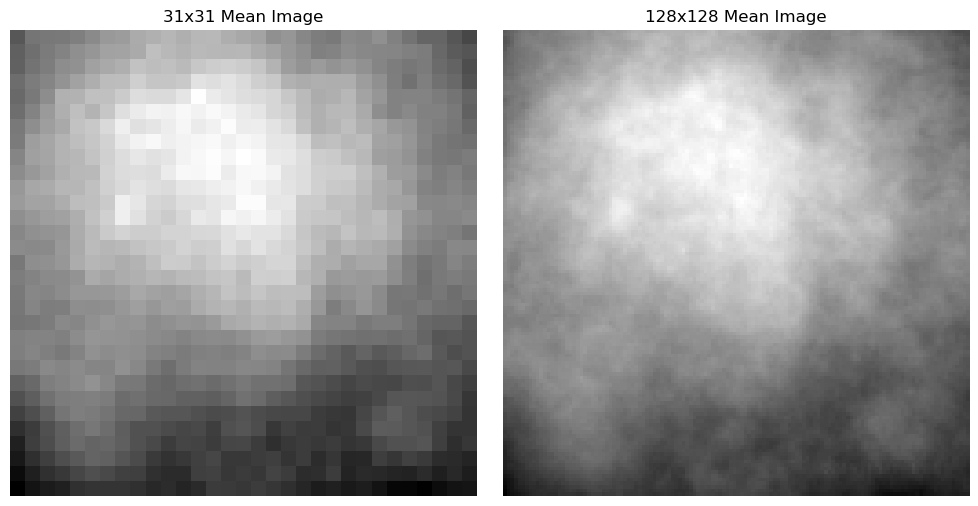

In [19]:
image_size_31 = (31, 31)
image_size_128 = (128, 128)

mean_image_31 = calculate_mean_image([dataset_test_31, dataset_validation_31], image_size_31, 'Average Mean Image (31x31)')
mean_image_128 = calculate_mean_image([dataset_test_128, dataset_validation_128], image_size_128, 'Average Mean Image (128x128)')

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(mean_image_31, cmap='gray')
plt.title('31x31 Mean Image')
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(mean_image_128, cmap='gray')
plt.title('128x128 Mean Image')
plt.axis("off")
plt.tight_layout()
plt.show()

The mean image for all the images combined looks like a fog, and we cant really determine any of or classes from this average image.

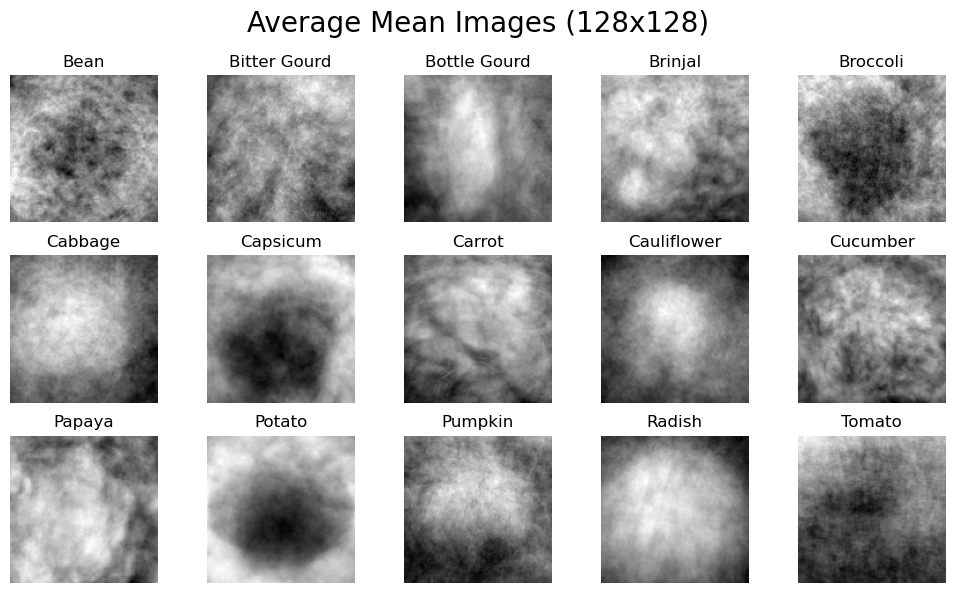

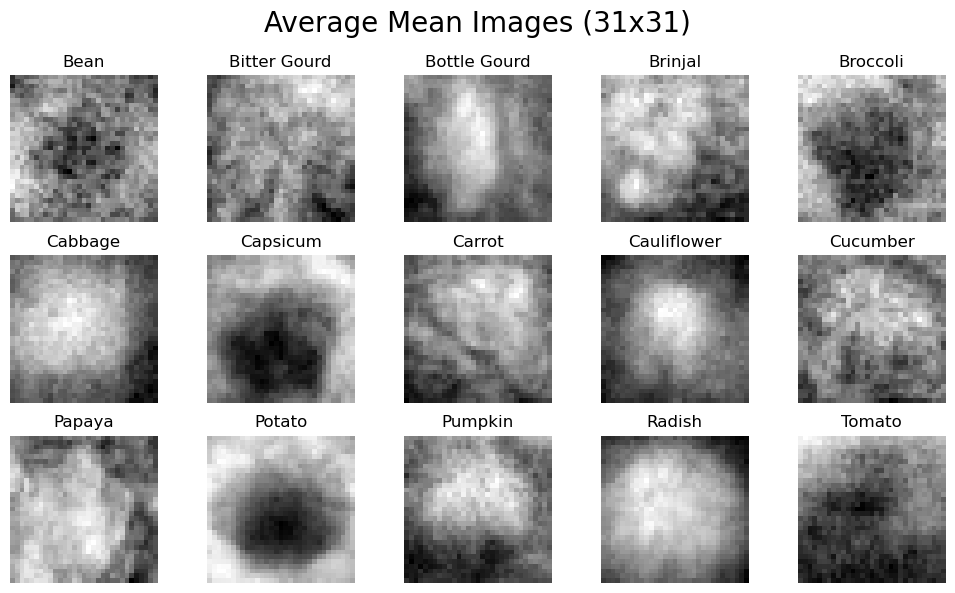

In [20]:
def calculate_class_mean_images(dataset, class_labels, image_size, title,amtOfImages=15):
    class_mean_images = {}  # To store the mean images for each class

    # Initialize mean images for each class
    for class_label in class_labels:
        class_mean_images[class_label] = np.zeros((image_size[0], image_size[1]), dtype=np.float64)

    num_images = 0

    for images, labels in dataset:
        for i, label in enumerate(labels):
            class_label = class_labels[np.argmax(label)]
            class_mean_images[class_label] += np.squeeze(images[i], axis=-1)
            num_images += 1

    num_images = amtOfImages
    row = int(np.sqrt(num_images))
    col = int(np.ceil(num_images / row))

    # Calculate and display the mean image for each class
    plt.figure(figsize=(10, 6))
    plt.suptitle(title, fontsize=20)

    for i, class_label in enumerate(class_labels):
        mean_image = class_mean_images[class_label] / (class_mean_images[class_label].max() + 1e-8)
        plt.subplot(row,col, i + 1)
        plt.imshow(mean_image, cmap='gray')
        plt.title(class_label)
        plt.axis("off")

    plt.tight_layout()
    plt.show()

calculate_class_mean_images(dataset_test_128, class_labels, image_size_128, 'Average Mean Images (128x128)')
calculate_class_mean_images(dataset_test_31, class_labels, image_size_31, 'Average Mean Images (31x31)')

Observations:
- We can see that the pixels for different classes kind of group together to show where the vegetable is. For example, the average image for potato has a cluster of black pixels in the center, roughly outlining a potato.
- However as the images in the dataset are quite complicated, it is quite hard to differentiate out individual classes without labels.

# Data Preprocessing
We need to preprocess our data to help our models to converge faster ,ie lesser time to train. And helps the model to generalise better and prevent it from overfitting.

### Normalizing our images
__Why do we need to normalize our images?__

As normalizing involves scalling the pixel values of our images between 0 and 1 , this results in our images all having a similiar data distribution. Which makes our models benefit from faster convergence during gradient descent and generalising better.

Normalizing the inputs in our context involves calculating the mean and standard deviation of the training dataset and then applying the following formula to each input:
$$
X_{} = \frac{X_{} - μ_{}}{σ_{}}
$$

In [21]:
# use rescaling
normalization_layer = tf.keras.layers.Rescaling(1./255)
normalized_dataset_train_31 = dataset_train_31.map(lambda x, y: (normalization_layer(x), y))

compute_statistics(normalized_dataset_train_31,'Normalised Training Images')

Normalised Training Images
Min Pixel Value: 0.0
Max Pixel Value: 1.0
Mean Pixel Value: 0.448397200505043
Standard Deviation: 0.21720750670021785


We can see that the range of the new normalised pixel values is between 0 - 1 

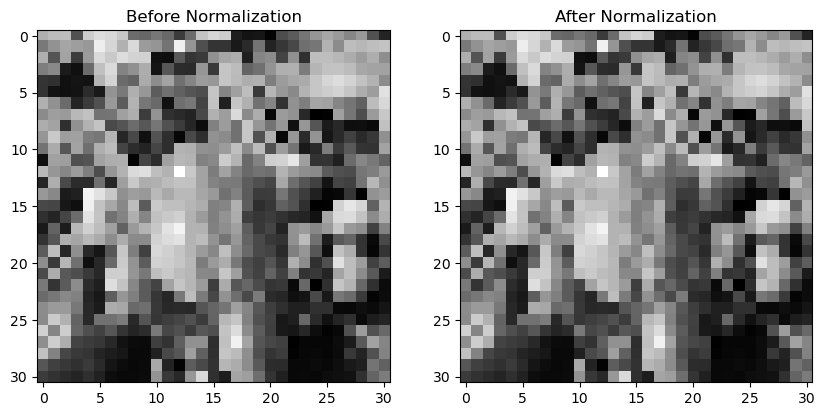

In [22]:
for images, labels in dataset_train_31.take(1):
    original_images = images

normalized_images = normalization_layer(original_images)

original_image = original_images[0]
normalized_image = normalized_images[0]

fig, ax = plt.subplots(ncols=2, figsize=(10, 5))

ax[0].imshow(original_image.numpy().squeeze(), cmap='gray')
ax[0].set_title('Before Normalization')

ax[1].imshow(normalized_image.numpy().squeeze(), cmap='gray')
ax[1].set_title('After Normalization')

plt.show()

Observations:
- We can see that normalization dosent significantly affect the visual appearance of our image. Since the original pixel values were already within the same range as before.

### Data Augementation
#### What are image augmentations?
It is a technique that artificially enhances the diversty and variability of our image dataset. It involves applying various transformations to our images such as rotations, flips, scaling, brightness adjustments, and cropping. It is mainly to provide our model with a broader range of training examples which improves its abilty to generalise and predict better on unseen data.
#### Why do we need to augment our images?
There are serveral reasons why we need to augment our images. 
- 1. It increases the amount of images in our train dataset, thus having more "data" for the model to train on. 
- 2. It helps with reducing overfitting,by exposing our model to a wider range of inputs, which promotes robustness and enhances its ability to handle variations.

##### Types of Image Augmentations we will be using:
- flipping (horizontal/ vertically)
- cropping

In [23]:
def augment_images(image,label,size):
    image = tf.map_fn(lambda img: tf.image.random_crop(img, size,seed=seed), image)
    image = tf.image.random_flip_left_right(image,seed=seed)
    image = tf.image.random_flip_up_down(image,seed=seed)
    return image,label

size_31 = [31, 31, 1] 
size_128 = [128, 128, 1]
train_generator_31 = dataset_train_31.map(lambda image, label: augment_images(image, label, size_31))
train_generator_128 = dataset_train_128.map(lambda image, label: augment_images(image, label, size_128))
#plot the augmented images

# Models
### How does a CNN differ from a ANN?
As the name of a CNN suggests, its convolution! As image data is store in arrays, It is deeply inefffcient and unsatisfying to flatten the whole image into an input layer and just feed it through a neural network. With neural network that recognises images having millions of tunable parameters. CNNs help solve that issue, with convolution and pooling layers!
### How does each layer affect our accuracy and efficiency?
We have serveral layers we want to look into here:
#### Convolution Layer(Convo2D)
> - They are basically require in our CNN model to __extract the features__ in our images and can learn hierarchical features.
> - However having too much convolution layers without regularization __can lead to overfitting__  :(
>- Convolutional layers are __computationally intensive__, but their use of shared weights reduces the overall number of parameters compared to fully connected layers, makes them computationally more efficient.  :)
#### Pooling layer
> - Pooling layers downsample feature maps from Convolution layers, reducing its spatial dimensions and computational requirements. :)
>- However excessive pooling may lead to information loss, affecting the model's ability to localize features precisely. :(
> - It increases computational efficiency by reducing the spatial dimensions, which can lead to faster training times and convergence. :)
#### Fully connected layer (Dense)
> - They are the main "brain" of our CNN, they are responsible for combining extracted features for final classification and can capture complex relationships in the data. :)
> - Too many parameters in dense layers can lead to overfitting, especially if our dataset is small which in our case it is. :(
> - Dense layers are alot more computationally expensive due to the large number of parameters, possibly slowing down training times. :( 
#### Dropout layer
> - Dropout layers prevent overfitting by randomly deactivating a fraction of neurons during training, encouraging our CNN to learn more robust features. :)
> - However if the dropout layer is too aggressive, it may prevent the model to learn any meaningful features or patterns, lowering the accuracy. :(


#### Models choosen 
We will be using these models on `31 x 31` and `128 x 128` images
- Convolution 2d Neural Network (base)
- Custom VG16 Network
- Custom ResNet Network

### Choosing Optimization Algorithm
Our choice of optimization algorithms plays a huge role in training CNN models. The 2 most common optimizers used in TensorFlow are __Adam__ and __Stochastic Gradient Descent (SGD)__. We first need to understand how these 2 optimization algorithms function:

__Adam Optimzer__
- Adam optimization is a stochastic gradient descent method that adapts its learning rates for each network weight __individually__. It is based on adaptive estimation of first-order (mean) and second-order (uncentered variance) moments. Adam is known for its fast convergence and efficiency in handling noisy or sparse gradients [[1]](https://optimization.cbe.cornell.edu/index.php?title=Adam).

__SGD__
- SGD is an  method that updates model parameters based on the gradient of the loss function with respect to those parameters. It is a classic optimization algorithm and is known for its simplicity [[2]](https://arxiv.org/abs/2010.05627).
#### Our choosen Optimization Algorithm : SGD
Why SGD? Eventhough Adam is faster in many cases as compared to SGD, this is due to it updating its learning rates indivdually for each weight and techniques such as coordinate-wise gradient clipping to handle noise effectivly. On the other hand, SGD may out perform Adam in image classification tasks, as Adam takes "shortcuts" where it dosent preserve the fine-grained details to distingush an image.

Therefore we will be using SGD as our optimizer

### Overfitting prevention
To prevent overfitting, we will be using Early Stopping, as it will stop model training once it begins to overfit.
Other strategies include:
- Data Augmentation
- Normalisation
- Dropout layers
- L1 and L2 Regularization


### Does size matter?
Does our input image size really matter? what else were you thinking!?
- Larger input sizes requires more complex models to capture intricate patterns and details in the data. We may need __deeper convolution networks__ to better learn features from our `128 x 128` pictures
- Smaller input sizes eg `31x31` might result in models that __generalize better__. Larger inputs eg `128x128` can lead to overfitting, where the model may memorize details specific to the training set but fail to generalize to new data.

> In summary, smaller sizes tend to give faster training times as models with fewer parameters converge more swiftly during optimization and is able to generalise better. On the other hand, larger sizes introduce increased model complexity, which enables the capture of the finner details and possibly improving performance on tasks requiring fine-grained information. However, this advantage comes at the cost of longer training times and heightened computational demands.


<!-- * compare between augmented/ non-augmented images

params for .fit (steps_per_epoch=None,
    validation_steps=None, verbose,callbacks) -->

## Utilty Functions

In [24]:
def compare_curves(history1, history2, title1, title2):
    plt.figure(figsize=(16, 6))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(history1['loss'], 'o-', label='Train Loss ' + title1)
    plt.plot(history1['val_loss'], 'o-', label='Validation Loss ' + title1)
    plt.plot(history2['loss'], '*--', label='Train Loss ' + title2)
    plt.plot(history2['val_loss'], '*--', label='Validation Loss ' + title2)
    plt.title('Loss Curve Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.ylim([0, 3])
    plt.legend()

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history1['accuracy'], 'o-', label='Train Accuracy ' + title1)
    plt.plot(history1['val_accuracy'], 'o-', label='Validation Accuracy ' + title1)
    plt.plot(history2['accuracy'], '*--', label='Train Accuracy ' + title2)
    plt.plot(history2['val_accuracy'], '*--', label='Validation Accuracy ' + title2)
    plt.title('Accuracy Curve Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.ylim([0, 1])
    plt.legend()

    plt.tight_layout()
    plt.show()

def evaluate_and_save_model(model, model_name, batch_size, save_dir='./models',save_models=True):
    # Create directory if it doesn't exist
    if save_models:
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        # Save the model
        model_path = os.path.join(save_dir, model_name + '.h5')
        #replace the model if it already exists
        if os.path.exists(model_path):
            os.remove(model_path)
        model.save(model_path)
        print('Saved trained model at %s ' % model_path)

        model_history = model.history.history
        if os.path.exists(os.path.join(save_dir, model_name +'_history'+'.json')):
            os.remove(os.path.join(save_dir, model_name + '_history'+'.json'))
        json.dump(model_history, open(os.path.join(save_dir, model_name +'_history'+ '.json'), 'w'))
        print('Saved trained model history at %s ' % os.path.join(save_dir, model_name +'_history'+ '.json'))
    else:
        model_history = model.history.history

    best_val_idx = np.argmax(model_history["val_accuracy"])
    result = {}
    result["Model Name"] = model_name
    result["Epochs"] = len(model_history["loss"])
    result["Batch Size"] = batch_size
    result["Train Loss"] = model_history["loss"][best_val_idx]
    result["Val Loss"] = model_history["val_loss"][best_val_idx]
    result["Train Acc"] = model_history["accuracy"][best_val_idx]
    result["Val Acc"] = model_history["val_accuracy"][best_val_idx]
    result["[Train - Val] Acc"] = result["Train Acc"] - result["Val Acc"]
    result["[Train - Val] Loss"] = result["Train Loss"] - result["Val Loss"]
    result_series = pd.Series(result, name=result["Model Name"])
    print(result_series)
    return 

from keras import backend as K
"""
source : https://stackoverflow.com/questions/47680984/does-input-dimension-resolution-affect-the-performance-of-convolutional-neural-n
"""
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

### Setting Parameters for our model
We will be setting the basic parameters for training our model.
- weight decay 
- steps per epoch 
- learning rate 
- momentum


In [25]:
weight_decay = 0.0005
steps_per_epoch = len(dataset_train_31) # 9028(total training samples) // 64(batch size) = 142
learning_rate = 0.02
momentum = 0.9

## Convo2D Neural Network (Base)

We will be using this model as a base to compare our other 2 models in later down the project. It will be a simple model with 2Convo2D and MaxPooling pairs and 2 hidden dense layers each with 128 neurons. The ReLu activation function will be applyed for the hidden layers and softmax for the output layer. As there are multiple category that we are predicting, we will be using the categorical_crossentropy as our loss function. We will be using both F1 and accuracry to measure our model.

#### Training without Data Augmentation for both `31x31` and` 128x128`

In [26]:
def create_Basemodel(input_shape, learning_rate, momentum, class_weights_dict, dataset_train, dataset_test, steps_per_epoch):
    tf.keras.backend.clear_session()
    model = Sequential()
    model.add(tf.keras.layers.Rescaling(1./255, input_shape=input_shape))
    model.add(Conv2D(64,(3,3),activation='relu'))
    model.add(MaxPooling2D((2,2)))
    model.add(Conv2D(64,(3,3),activation='relu'))
    model.add(MaxPooling2D((2,2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(15, activation='softmax'))
    model.compile(optimizer=SGD(learning_rate=learning_rate, momentum=momentum), loss='categorical_crossentropy', metrics=['accuracy',f1_m])
    model.fit(dataset_train, epochs=100, validation_data=dataset_test, class_weight=class_weights_dict,callbacks=[EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')],steps_per_epoch=steps_per_epoch)
    return model

In [27]:
%%time
BaseModel_31 = create_Basemodel((31,31,1),learning_rate,momentum,class_weights_dict,dataset_train_31,dataset_test_31,steps_per_epoch)

Epoch 1/100


142/142 [==============================] - 7s 11ms/step - loss: 0.1508 - accuracy: 0.0819 - f1_m: 0.0000e+00 - val_loss: 2.7039 - val_accuracy: 0.0923 - val_f1_m: 0.0000e+00
Epoch 2/100
142/142 [==============================] - 1s 10ms/step - loss: 0.1505 - accuracy: 0.1194 - f1_m: 0.0000e+00 - val_loss: 2.6989 - val_accuracy: 0.1043 - val_f1_m: 0.0000e+00
Epoch 3/100
142/142 [==============================] - 1s 10ms/step - loss: 0.1501 - accuracy: 0.1177 - f1_m: 0.0000e+00 - val_loss: 2.6913 - val_accuracy: 0.1057 - val_f1_m: 0.0000e+00
Epoch 4/100
142/142 [==============================] - 1s 9ms/step - loss: 0.1496 - accuracy: 0.1038 - f1_m: 0.0000e+00 - val_loss: 2.6778 - val_accuracy: 0.1317 - val_f1_m: 0.0000e+00
Epoch 5/100
142/142 [==============================] - 1s 10ms/step - loss: 0.1486 - accuracy: 0.1533 - f1_m: 0.0000e+00 - val_loss: 2.6518 - val_accuracy: 0.1523 - val_f1_m: 0.0000e+00
Epoch 6/100
142/142 [==============================] - 1s 10ms/step - loss: 0.1465 

In [28]:
%%time
BaseModel_128 =  create_Basemodel((128,128,1),learning_rate,momentum,class_weights_dict,dataset_train_128,dataset_test_128,steps_per_epoch)

Epoch 1/100
142/142 [==============================] - 6s 38ms/step - loss: 0.1497 - accuracy: 0.1000 - f1_m: 0.0000e+00 - val_loss: 2.6450 - val_accuracy: 0.1183 - val_f1_m: 0.0000e+00
Epoch 2/100
142/142 [==============================] - 5s 33ms/step - loss: 0.1437 - accuracy: 0.1398 - f1_m: 0.0011 - val_loss: 2.5023 - val_accuracy: 0.1827 - val_f1_m: 0.0091
Epoch 3/100
142/142 [==============================] - 5s 34ms/step - loss: 0.1361 - accuracy: 0.2187 - f1_m: 0.0094 - val_loss: 2.3737 - val_accuracy: 0.2460 - val_f1_m: 0.0111
Epoch 4/100
142/142 [==============================] - 5s 34ms/step - loss: 0.1280 - accuracy: 0.2887 - f1_m: 0.0208 - val_loss: 2.2438 - val_accuracy: 0.2780 - val_f1_m: 0.0259
Epoch 5/100
142/142 [==============================] - 5s 37ms/step - loss: 0.1196 - accuracy: 0.3342 - f1_m: 0.0689 - val_loss: 2.0917 - val_accuracy: 0.3477 - val_f1_m: 0.1033
Epoch 6/100
142/142 [==============================] - 5s 34ms/step - loss: 0.1110 - accuracy: 0.3858 

In [29]:
BaseModel_128.summary()
BaseModel_31.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 128, 128, 1)       0         
                                                                 
 conv2d (Conv2D)             (None, 126, 126, 64)      640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 57600)             0

Observations:
- We can see that the bigger the input size greatly increases the number of parameters we need to train, thus increasing the training time and likely hood of overfitting in the bigger input size.

In [30]:
# evaluate_and_save_model(model, model.history, 'BaseModel', 64)
evaluate_and_save_model(BaseModel_128, 'BaseModel_128', 64,save_models=True)
evaluate_and_save_model(BaseModel_31, 'BaseModel_31', 64,save_models=True)

Saved trained model at ./models\BaseModel_128.h5 
Saved trained model history at ./models\BaseModel_128_history.json 
Model Name            BaseModel_128
Epochs                           36
Batch Size                       64
Train Loss                  0.00177
Val Loss                   0.935704
Train Acc                  0.995237
Val Acc                    0.792667
[Train - Val] Acc           0.20257
[Train - Val] Loss        -0.933934
Name: BaseModel_128, dtype: object
Saved trained model at ./models\BaseModel_31.h5 
Saved trained model history at ./models\BaseModel_31_history.json 
Model Name            BaseModel_31
Epochs                          78
Batch Size                      64
Train Loss                0.005065
Val Loss                  0.657477
Train Acc                 0.976185
Val Acc                      0.835
[Train - Val] Acc         0.141185
[Train - Val] Loss       -0.652413
Name: BaseModel_31, dtype: object


In [31]:
baseline_128_history = json.load(open('./models/BaseModel_128_history.json', 'r'))
baseline_31_history = json.load(open('./models/BaseModel_31_history.json', 'r'))

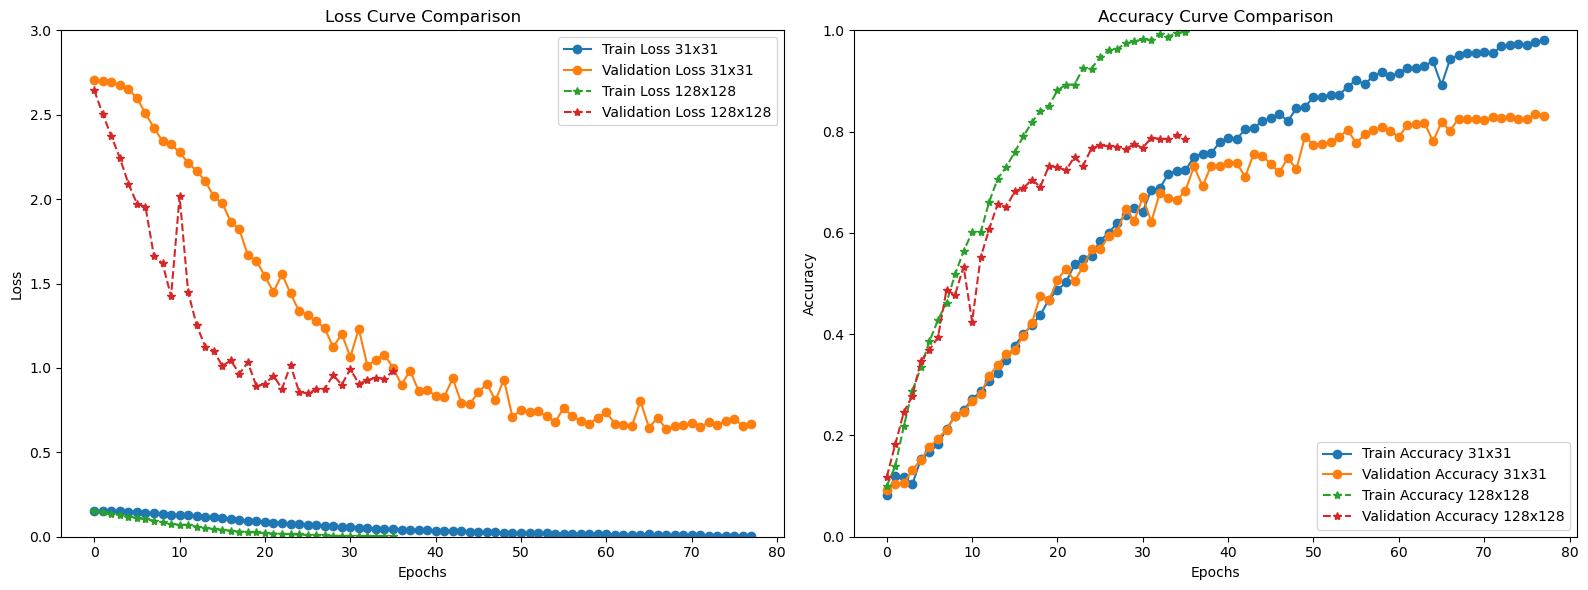

In [32]:
compare_curves(baseline_31_history, baseline_128_history, '31x31', '128x128')

__Obersevations:__

- We can see as when the model increases in epochs, it becomes more generalise and our loss functions starts decreasing as well. However we can see that our model starts to overfit around the 30 epoch mark. We will be comparing and utilising the different overfiting prevention stratergiers latter on in the project.
- As expected , our `128x128` model overfitts alot more and alot faster, thus stopping relatively early during training.

### Training with Data Augmentation
We will now train our baseline model on the dataset that we have augmented

In [33]:
%%time
BaseModel_128_DA = create_Basemodel((128,128,1),learning_rate,momentum,class_weights_dict,train_generator_128,dataset_test_128,steps_per_epoch)

Epoch 1/100
142/142 [==============================] - 5s 34ms/step - loss: 0.1504 - accuracy: 0.1151 - f1_m: 0.0000e+00 - val_loss: 2.6883 - val_accuracy: 0.0903 - val_f1_m: 0.0000e+00
Epoch 2/100
142/142 [==============================] - 5s 33ms/step - loss: 0.1485 - accuracy: 0.1364 - f1_m: 0.0000e+00 - val_loss: 2.6266 - val_accuracy: 0.1453 - val_f1_m: 0.0000e+00
Epoch 3/100
142/142 [==============================] - 5s 33ms/step - loss: 0.1430 - accuracy: 0.1677 - f1_m: 0.0022 - val_loss: 2.4710 - val_accuracy: 0.1853 - val_f1_m: 0.0162
Epoch 4/100
142/142 [==============================] - 5s 33ms/step - loss: 0.1372 - accuracy: 0.1910 - f1_m: 0.0064 - val_loss: 2.3936 - val_accuracy: 0.2030 - val_f1_m: 0.0047
Epoch 5/100
142/142 [==============================] - 5s 34ms/step - loss: 0.1315 - accuracy: 0.2372 - f1_m: 0.0107 - val_loss: 2.3046 - val_accuracy: 0.2467 - val_f1_m: 0.0376
Epoch 6/100
142/142 [==============================] - 5s 33ms/step - loss: 0.1284 - accuracy:

In [34]:
%%time
BaseModel_31_DA = create_Basemodel((31,31,1),learning_rate,momentum,class_weights_dict,train_generator_31,dataset_test_31,steps_per_epoch)

Epoch 1/100
142/142 [==============================] - 2s 10ms/step - loss: 0.1508 - accuracy: 0.0792 - f1_m: 0.0000e+00 - val_loss: 2.7045 - val_accuracy: 0.0710 - val_f1_m: 0.0000e+00
Epoch 2/100
142/142 [==============================] - 1s 9ms/step - loss: 0.1506 - accuracy: 0.0905 - f1_m: 0.0000e+00 - val_loss: 2.7001 - val_accuracy: 0.0690 - val_f1_m: 0.0000e+00
Epoch 3/100
142/142 [==============================] - 1s 9ms/step - loss: 0.1503 - accuracy: 0.0947 - f1_m: 0.0000e+00 - val_loss: 2.6958 - val_accuracy: 0.0873 - val_f1_m: 0.0000e+00
Epoch 4/100
142/142 [==============================] - 1s 9ms/step - loss: 0.1500 - accuracy: 0.1252 - f1_m: 0.0000e+00 - val_loss: 2.6903 - val_accuracy: 0.1223 - val_f1_m: 0.0000e+00
Epoch 5/100
142/142 [==============================] - 1s 9ms/step - loss: 0.1497 - accuracy: 0.1406 - f1_m: 0.0000e+00 - val_loss: 2.6819 - val_accuracy: 0.1407 - val_f1_m: 0.0000e+00
Epoch 6/100
142/142 [==============================] - 1s 9ms/step - loss:

In [35]:
evaluate_and_save_model(BaseModel_128_DA,  'BaseModel_128_DA', 64,save_models=True)
evaluate_and_save_model(BaseModel_31_DA, 'BaseModel_31_DA', 64,save_models=True)

Saved trained model at ./models\BaseModel_128_DA.h5 
Saved trained model history at ./models\BaseModel_128_DA_history.json 
Model Name            BaseModel_128_DA
Epochs                              42
Batch Size                          64
Train Loss                    0.008568
Val Loss                      0.915019
Train Acc                     0.951927
Val Acc                       0.773667
[Train - Val] Acc             0.178261
[Train - Val] Loss           -0.906451
Name: BaseModel_128_DA, dtype: object
Saved trained model at ./models\BaseModel_31_DA.h5 
Saved trained model history at ./models\BaseModel_31_DA_history.json 
Model Name            BaseModel_31_DA
Epochs                            100
Batch Size                         64
Train Loss                   0.020165
Val Loss                     0.614425
Train Acc                    0.873948
Val Acc                      0.815667
[Train - Val] Acc            0.058281
[Train - Val] Loss           -0.59426
Name: BaseModel_31_DA, 

In [36]:
DAbaseline_128_history = json.load(open('./models/BaseModel_128_DA_history.json', 'r'))
DAbaseline_31_history = json.load(open('./models/BaseModel_31_DA_history.json', 'r'))

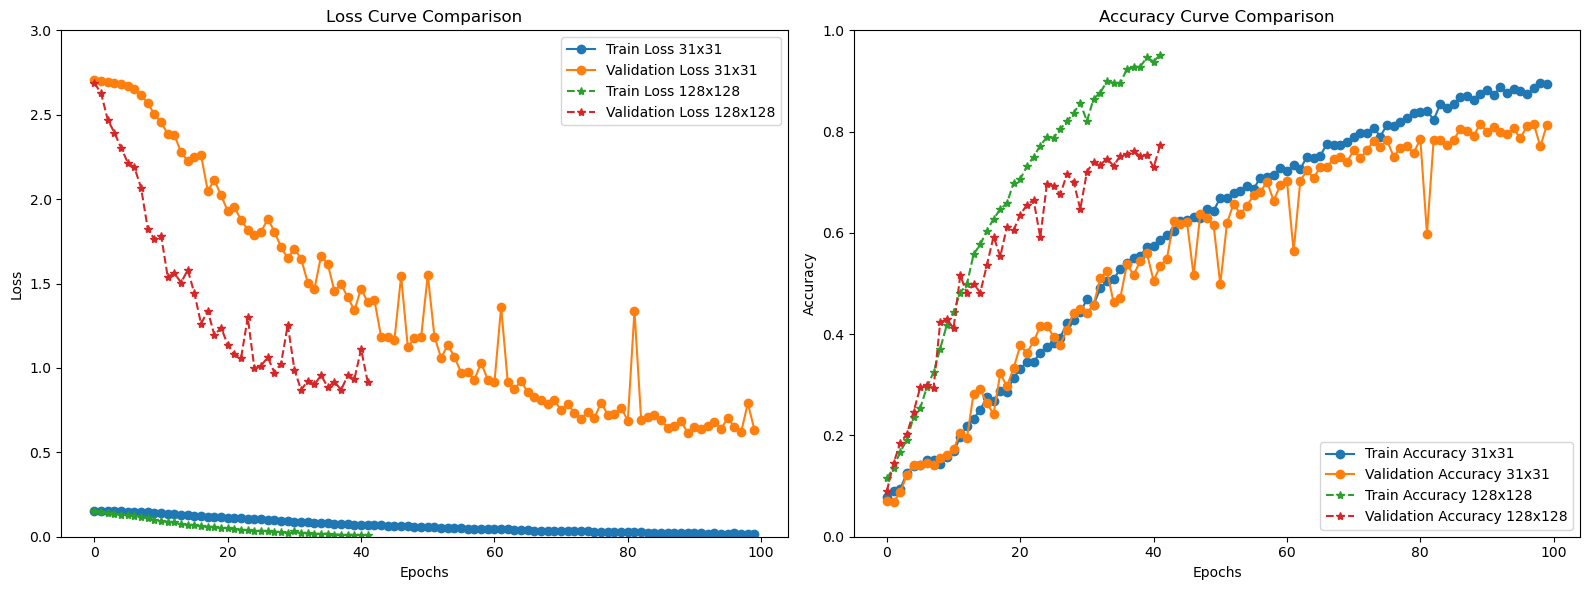

In [37]:
compare_curves(DAbaseline_31_history, DAbaseline_128_history, '31x31', '128x128')

Observations:
- We can see that comparing to the model without data agumentation, the model perfoms worse. However looking at the accuracy and loss graphs, we can see that the model does not overfit as badly as the model trained without data augmentation.
- We still see that the `128x128` model overfitts alot more and faster as compared to our `31x31` model

#### Training with Data Augmentation and Regularization

In [38]:
def create_Basemodel_regularization(input_shape, learning_rate, momentum, class_weights_dict, dataset_train, dataset_test, steps_per_epoch, weight_decay):
    tf.keras.backend.clear_session()
    model = Sequential()
    model.add(tf.keras.layers.Rescaling(1./255, input_shape=input_shape))
    model.add(Conv2D(64, (3,3), activation='relu', kernel_regularizer=l2(weight_decay)))
    model.add(MaxPooling2D((2,2)))
    model.add(Conv2D(64, (3,3), activation='relu', kernel_regularizer=l2(weight_decay)))
    model.add(MaxPooling2D((2,2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_regularizer=l2(weight_decay)))
    model.add(Dense(128, activation='relu', kernel_regularizer=l2(weight_decay)))
    model.add(Dense(15, activation='softmax'))
    model.compile(optimizer=SGD(learning_rate=learning_rate, momentum=momentum), loss='categorical_crossentropy', metrics=['accuracy',f1_m])
    model.fit(dataset_train, epochs=100, validation_data=dataset_test, class_weight=class_weights_dict,callbacks=[EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')],steps_per_epoch=steps_per_epoch)
    return model

In [39]:
%%time
BaseModel_31_DA_RE = create_Basemodel_regularization((31,31,1),learning_rate,momentum,class_weights_dict,dataset_train_31,dataset_test_31,steps_per_epoch,weight_decay)

Epoch 1/100


142/142 [==============================] - 2s 11ms/step - loss: 0.3646 - accuracy: 0.0767 - f1_m: 0.0000e+00 - val_loss: 2.9122 - val_accuracy: 0.0820 - val_f1_m: 0.0000e+00
Epoch 2/100
142/142 [==============================] - 1s 10ms/step - loss: 0.3526 - accuracy: 0.1041 - f1_m: 0.0000e+00 - val_loss: 2.8976 - val_accuracy: 0.0847 - val_f1_m: 0.0000e+00
Epoch 3/100
142/142 [==============================] - 1s 10ms/step - loss: 0.3413 - accuracy: 0.1053 - f1_m: 0.0000e+00 - val_loss: 2.8838 - val_accuracy: 0.0897 - val_f1_m: 0.0000e+00
Epoch 4/100
142/142 [==============================] - 1s 10ms/step - loss: 0.3306 - accuracy: 0.1150 - f1_m: 0.0000e+00 - val_loss: 2.8703 - val_accuracy: 0.1120 - val_f1_m: 0.0000e+00
Epoch 5/100
142/142 [==============================] - 1s 10ms/step - loss: 0.3205 - accuracy: 0.1276 - f1_m: 0.0000e+00 - val_loss: 2.8564 - val_accuracy: 0.1490 - val_f1_m: 0.0000e+00
Epoch 6/100
142/142 [==============================] - 2s 10ms/step - loss: 0.3109

In [40]:
%%time
BaseModel_128_DA_RE = create_Basemodel_regularization((128,128,1),learning_rate,momentum,class_weights_dict,dataset_train_128,dataset_test_128,steps_per_epoch,weight_decay)

Epoch 1/100


142/142 [==============================] - 5s 34ms/step - loss: 0.3689 - accuracy: 0.0824 - f1_m: 0.0000e+00 - val_loss: 2.8937 - val_accuracy: 0.1353 - val_f1_m: 0.0000e+00
Epoch 2/100
142/142 [==============================] - 5s 34ms/step - loss: 0.3540 - accuracy: 0.1019 - f1_m: 0.0000e+00 - val_loss: 2.7873 - val_accuracy: 0.1327 - val_f1_m: 0.0000e+00
Epoch 3/100
142/142 [==============================] - 5s 34ms/step - loss: 0.3361 - accuracy: 0.1593 - f1_m: 0.0013 - val_loss: 2.6485 - val_accuracy: 0.2060 - val_f1_m: 0.0154
Epoch 4/100
142/142 [==============================] - 5s 34ms/step - loss: 0.3191 - accuracy: 0.2395 - f1_m: 0.0071 - val_loss: 2.4950 - val_accuracy: 0.2790 - val_f1_m: 0.0212
Epoch 5/100
142/142 [==============================] - 5s 34ms/step - loss: 0.3011 - accuracy: 0.3064 - f1_m: 0.0208 - val_loss: 2.3876 - val_accuracy: 0.2943 - val_f1_m: 0.0567
Epoch 6/100
142/142 [==============================] - 5s 33ms/step - loss: 0.2833 - accuracy: 0.3570 - f1

In [41]:
evaluate_and_save_model(BaseModel_128_DA_RE, 'BaseModel_128_DA_RE', 64,save_models=True)
evaluate_and_save_model(BaseModel_31_DA_RE, 'BaseModel_31_DA_RE', 64,save_models=True)

Saved trained model at ./models\BaseModel_128_DA_RE.h5 
Saved trained model history at ./models\BaseModel_128_DA_RE_history.json 
Model Name            BaseModel_128_DA_RE
Epochs                                 74
Batch Size                             64
Train Loss                       0.033091
Val Loss                         0.812622
Train Acc                         0.98992
Val Acc                          0.792667
[Train - Val] Acc                0.197254
[Train - Val] Loss              -0.779531
Name: BaseModel_128_DA_RE, dtype: object
Saved trained model at ./models\BaseModel_31_DA_RE.h5 
Saved trained model history at ./models\BaseModel_31_DA_RE_history.json 
Model Name            BaseModel_31_DA_RE
Epochs                               100
Batch Size                            64
Train Loss                       0.06843
Val Loss                         0.79032
Train Acc                       0.795968
Val Acc                         0.774667
[Train - Val] Acc               0.02

In [42]:
DAREbaseline_128_history = json.load(open('./models/BaseModel_128_DA_RE_history.json', 'r'))
DAREbaseline_31_history = json.load(open('./models/BaseModel_31_DA_RE_history.json', 'r'))

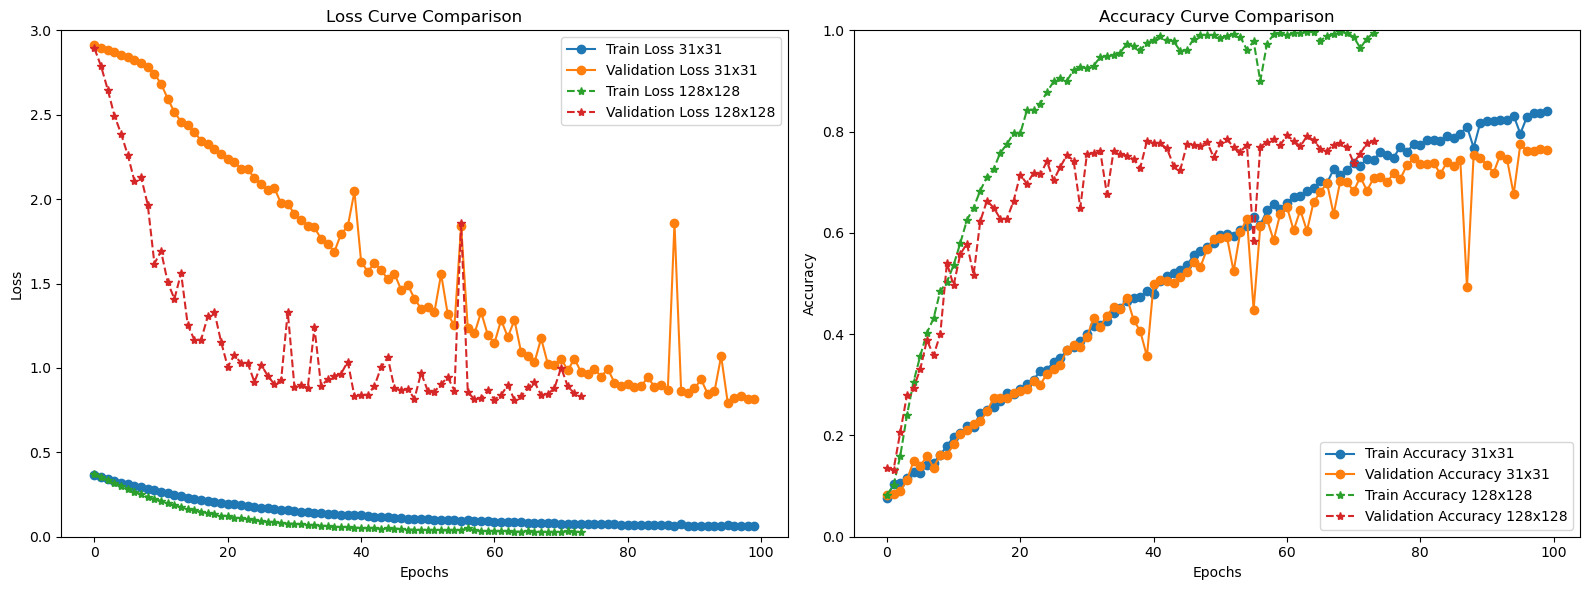

In [43]:
compare_curves(DAREbaseline_31_history, DAREbaseline_128_history, '31x31', '128x128')

Observations:
- We can see that with the inclusion of L2 Regularization, our models tend to not overfit as much as the previous models.
- We can see that our `31x31` model has improved alot compared with training on only augmented images. However, our `128x128` model does not improve at all and even deproves compared with training on only augmented images.

### How can we suit our models to the different sizes?
As mentioned early, bigger input sizes tend to __overfit more__ and have __longer training times__ due to the increased amount of trainable parameters. We also need __deeper networks__ to allow our `128x128` model to better extract complex features.
- We will be using the same stratagies to prevent overfitting in both `31x31` and `128x128` models
- We will introduce more layers for our `128x128` model as compared to our `31x31` model.
- We cant really do anything about the longer training time, unless we reduce our parameters compare to our `31x31` model, however that would defeat the purpose of making our `128x128` model deeper in the first place. :(

## Custom CNN Network
Resnets (Residual Networks) were first introduced in 2015 ,by Microsoft researchers, Kaiming He, Xiangyu Zhang, Shaoqing Ren and Jian Sun. In their paper "Deep Residual Learning for Image Recognition" [[3]](https://arxiv.org/abs/1512.03385). They talked on the problem of how deeper neural networks are harder to train and they provide evidence on how Resnets are easier to optimize and learn in much deeper neural networks as compared to other neural networks such as VGG nets during 2015.
#### First of all why Resnet?
Resnet's unqiue architechture of skipping connections backwards from later layers to intital filters, where there are 2 pathways for the gradient to transit back to the inputlayer while tranversing a residual block. allowing us to combat a big problem in neural networks, __vanishing/exploding gradients__. Where when our model network gets too deep and the gradient calculated from backpropagation gradually goes to 0 after multiple applications of the chain rule. Resnet allows us to have deeper and more complex models without encountering the problem of vanishing and exploding gradients.
#### Architechture of a regular residual network
<img src="./images/full_resnet_image.png" style="width: 30%">

[Source](https://www.analyticsvidhya.com/blog/2021/09/building-resnet-34-model-using-pytorch-a-guide-for-beginners/)

Here for example is a 34 layer Resnet, where the main thing that stands out is the skip connections it has. While th architecture is organized into four stages with 3, 4, 6, and 3 residual blocks.The residual blocks consist of 2 stacked convolutional layers with batch normalization and ReLU activations. After the last stage, a global average pooling layer is applied to reduce spatial dimensions. We can see that there are 2 different types of skip connections in this model (dotted and non-dotted lines). An `identity skip connection` and a `projection skip connection`. __What is the difference between the 2?__ In projection skip connections,it is similair to a normal identity skip connection except additional operations(eg. a 1x1 convolutional layer) are applied to the input to match the spatial dimensions of the output of our residual block.

In [77]:
resnet50_example = tf.keras.applications.ResNet50(
    include_top=False,
    weights=None,
    input_shape=(128, 128, 1),
    pooling='avg',
    classes=15,
)
resnet50_example.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_25 (InputLayer)          [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 134, 1)  0           ['input_25[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, 64, 64)   3200        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 64, 64, 64)   256         ['conv1_conv[0][0]']      

### How are we gonna to modify it to suit our project??
- reduce amt of filters
- going to make a 10 layered resnet for 31x31 and 12 for 128x128 
- including dropout layer 
- L2 regularization

In [92]:
def vgg_block(X, num_convs, num_filters):
    """
    A VGG block with a skip connection. The block consists of several convolutional layers followed by a max pooling layer.
    
    Parameters:
    - X: The input tensor
    - num_convs: The number of convolutional layers in the block
    - num_filters: The number of filters in the convolutional layers
    """
    # Apply a 1x1 convolution with a stride of 2 to the input tensor
    # X_shortcut = Conv2D(num_filters, (1, 1), strides=(2, 2))(X)

    for _ in range(num_convs):
        X = Conv2D(num_filters, (3, 3), padding='same')(X)
        X = BatchNormalization()(X)
        X = Activation('relu')(X)

    X = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(X)

    # Add the shortcut connection to the main path
    # X = Add()([X, X_shortcut])

    return X

def create_model(input_shape, num_classes):
    X_input = Input(input_shape)

    # Add VGG blocks
    X = vgg_block(X_input, 2, 16)
    X = vgg_block(X, 2, 32)
    X = vgg_block(X, 2, 64)
    X = vgg_block(X, 3, 128)
    X = vgg_block(X, 3, 256)

    # Flatten the output from the last VGG block
    X = Flatten()(X)

    # Add a dense layer for classification
    X = Dense(256, activation='relu')(X)
    X = Dense(256, activation='relu')(X)
    X = Dropout(0.2)(X)
    X = Dense(num_classes, activation='softmax')(X)

    # Create the model
    model = Model(inputs=X_input, outputs=X)

    return model

# Create the model
model = create_model((128, 128, 1), 15)

# Compile the model
model.compile(optimizer=SGD(learning_rate=0.05,momentum=momentum), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_37 (InputLayer)       [(None, 128, 128, 1)]     0         
                                                                 
 conv2d_395 (Conv2D)         (None, 128, 128, 16)      160       
                                                                 
 batch_normalization_384 (Ba  (None, 128, 128, 16)     64        
 tchNormalization)                                               
                                                                 
 activation_380 (Activation)  (None, 128, 128, 16)     0         
                                                                 
 conv2d_396 (Conv2D)         (None, 128, 128, 16)      2320      
                                                                 
 batch_normalization_385 (Ba  (None, 128, 128, 16)     64        
 tchNormalization)                                         

In [93]:
model.fit(dataset_train_128, epochs=20, validation_data=dataset_test_128, class_weight=class_weights_dict,callbacks=[EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')],steps_per_epoch=steps_per_epoch)

Epoch 1/20


142/142 [==============================] - 10s 62ms/step - loss: 0.1035 - accuracy: 0.4040 - val_loss: 2.7602 - val_accuracy: 0.1623
Epoch 2/20
142/142 [==============================] - 9s 60ms/step - loss: 0.0537 - accuracy: 0.6973 - val_loss: 2.8959 - val_accuracy: 0.2750
Epoch 3/20
142/142 [==============================] - 9s 60ms/step - loss: 0.0322 - accuracy: 0.8197 - val_loss: 1.2648 - val_accuracy: 0.6213
Epoch 4/20
142/142 [==============================] - 9s 61ms/step - loss: 0.0163 - accuracy: 0.9062 - val_loss: 0.5769 - val_accuracy: 0.8147
Epoch 5/20
142/142 [==============================] - 9s 60ms/step - loss: 0.0155 - accuracy: 0.9113 - val_loss: 1.2425 - val_accuracy: 0.6727
Epoch 6/20
142/142 [==============================] - 9s 60ms/step - loss: 0.0107 - accuracy: 0.9415 - val_loss: 1.5933 - val_accuracy: 0.6283
Epoch 7/20
142/142 [==============================] - 9s 60ms/step - loss: 0.0279 - accuracy: 0.8538 - val_loss: 0.5788 - val_accuracy: 0.8210
Epoch 8/2

In [94]:
evaluate_and_save_model(model, 'VGG', 64,save_models=True)

Saved trained model at ./models\VGG.h5 
Saved trained model history at ./models\VGG_history.json 
Model Name                 VGG
Epochs                      20
Batch Size                  64
Train Loss            0.001782
Val Loss              0.134229
Train Acc             0.989366
Val Acc                  0.962
[Train - Val] Acc     0.027366
[Train - Val] Loss   -0.132447
Name: VGG, dtype: object


In [78]:
# def identity_block(X, f, filters):
#     F1, F2, F3 = filters

#     X_shortcut = X

#     X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(1, 1), padding='valid')(X)
#     X = BatchNormalization(axis=3)(X)
#     X = Activation('relu')(X)

#     X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same')(X)
#     X = BatchNormalization(axis=3)(X)
#     X = Activation('relu')(X)

#     X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid')(X)
#     X = BatchNormalization(axis=3)(X)

#     X = Add()([X, X_shortcut])
#     X = Activation('relu')(X)

#     return X

# def projection_block(X, f, filters, s=2):
#     F1, F2, F3 = filters

#     X_shortcut = X

#     X = Conv2D(F1, (1, 1), strides=(s, s))(X)
#     X = BatchNormalization(axis=3)(X)
#     X = Activation('relu')(X)

#     X = Conv2D(F2, (f, f), strides=(1, 1), padding='same')(X)
#     X = BatchNormalization(axis=3)(X)
#     X = Activation('relu')(X)

#     X = Conv2D(F3, (1, 1), strides=(1, 1), padding='valid')(X)
#     X = BatchNormalization(axis=3)(X)

#     X_shortcut = Conv2D(F3, (1, 1), strides=(s, s))(X_shortcut)
#     X_shortcut = BatchNormalization(axis=3)(X_shortcut)

#     X = Add()([X, X_shortcut])
#     X = Activation('relu')(X)

#     return X
# def ResNet50(input_shape=(128, 128, 1), classes=15):
#     X_input = Input(input_shape)

#     # Stage 1
#     X = Conv2D(64, (7, 7), strides=(2, 2), padding='same')(X_input)
#     X = BatchNormalization(axis=3)(X)
#     X = Activation('relu')(X)
#     X = MaxPooling2D((3, 3), strides=(2, 2))(X)

#     X = projection_block(X, f=3, filters=[32, 32, 128], s=1)
#     X = identity_block(X, 3, [32, 32, 128])
#     X = identity_block(X, 3, [32, 32, 128])

#     # Stage 2
#     X = projection_block(X, f=3, filters=[64, 64, 256], s=1)
#     X = identity_block(X, 3, [64, 64, 256])
#     X = identity_block(X, 3, [64, 64, 256])

#     # Stage 3
#     X = projection_block(X, f=3, filters=[128, 128, 512], s=2)
#     X = identity_block(X, 3, [128, 128, 512])
#     X = identity_block(X, 3, [128, 128, 512])

#     # AVGPOOL
#     X = AveragePooling2D(pool_size=(2, 2), padding='same')(X)

#     # Output layer
#     X = Flatten()(X)
#     X = Dropout(0.2)(X)
#     X = Dense(classes, activation='softmax')(X)


#     # Create model
#     model = Model(inputs=X_input, outputs=X, name='ResNet50')

#     return model

# # Create the model
# model = ResNet50(input_shape=(128, 128, 1), classes=15)

# # Compile the model
# model.compile(optimizer='SGD', loss='categorical_crossentropy', metrics=['accuracy'])
# model.summary()


In [79]:
# def identity_block(X, filter):
#     X_shortcut = X

#     X = Conv2D(filters=filter, kernel_size=(3,3), padding='same')(X)  # Add padding here
#     X = BatchNormalization(axis=3)(X)
#     X = Activation('relu')(X)

#     X = Conv2D(filters=filter, kernel_size=(3,3), padding='same')(X)  # Add padding here
#     X = BatchNormalization(axis=3)(X)
#     X = Activation('relu')(X)

#     X = Add()([X, X_shortcut])
#     X = Activation('relu')(X)

#     return X

# def projection_block(X,filter):

#     X_shortcut = X

#     X = Conv2D(filter, (3,3), padding='same')(X)  # Add padding here
#     X = BatchNormalization(axis=3)(X)
#     X = Activation('relu')(X)

#     X = Conv2D(filter, (3,3), padding='same')(X)
#     X = BatchNormalization(axis=3)(X)
#     X = Activation('relu')(X)

#     X_shortcut = Conv2D(filter, (1, 1))(X_shortcut)
#     X_shortcut = BatchNormalization(axis=3)(X_shortcut)
#     X = Add()([X, X_shortcut])
#     X = Activation('relu')(X)

#     return X

# def ResNet50(input_shape=(128, 128, 1), classes=15):
#     X_input = Input(input_shape)

#     # Stage 1
#     X = ZeroPadding2D((3, 3))(X_input)
#     X = Conv2D(64, (7, 7), strides=(2, 2), padding='same')(X)
#     X = BatchNormalization(axis=3)(X)
#     X = Activation('relu')(X)
#     X = MaxPooling2D((3, 3), strides=(2, 2))(X)

#     # Stage 2
#     X = projection_block(X,32)
#     X = identity_block(X,32)
#     X = identity_block(X,32)

#     # Stage 3
#     X = projection_block(X,64)
#     X = identity_block(X,64)
#     X = identity_block(X,64)

#     # Stage 4
#     # X = projection_block(X,128)
#     # X = identity_block(X,128)
#     # X = identity_block(X,128)

#     # AVGPOOL
#     X = AveragePooling2D(pool_size=(2, 2), padding='same')(X)

#     # Output layer
#     X = Flatten()(X)

#     X = Dense(256, activation='relu')(X)
#     X = Dense(256, activation='relu')(X)
#     X = Dropout(0.5)(X)
#     X = Dense(classes, activation='softmax')(X)

#     # Create model
#     model = Model(inputs=X_input, outputs=X, name='ResNet50')

#     return model

# # Create the model
# model = ResNet50(input_shape=(128, 128, 1), classes=15)

# # Compile the model
# model.compile(optimizer=SGD(learning_rate=learning_rate,momentum=momentum), loss='categorical_crossentropy', metrics=['accuracy'])
# model.summary()
# # Train the model
# model.fit(dataset_train_128, epochs=10, validation_data=dataset_test_128,callbacks=[EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')],steps_per_epoch=steps_per_epoch)

#### Training without Data Augmentation

#### Training with Data Augmentation

# Model Improvement
- using cosine annealing learning rate scheduler
- keras tuner
- eg
- eg

# Final Model
- evaluate final model on validation dataset
- get classification report
- error analysis

# Summary